In [1]:
# !pip install torchmetrics
import datetime
import errno
import os
import time
import numpy as np
import pandas as pd 
import torch
import torchvision
import torch.distributed as dist
import matplotlib.pyplot as plt
import math
from collections import defaultdict, deque
from PIL import Image
from torchvision import models
from torchmetrics.detection.mean_ap import MeanAveragePrecision
# from torchmetrics.detection.iou import IntersectionOverUnion
from torch.utils.tensorboard import SummaryWriter
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor,FasterRCNN_MobileNet_V3_Large_320_FPN_Weights
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.transforms import functional as F

# os.listdir('../working/voc/VOCdevkit/VOC2012/JPEGImages')[0]
# img_path = '../working/voc/VOCdevkit/VOC2012/JPEGImages/2012_002765.jpg'

classdict = {'person', 'bird', 'cat', 'cow', 'dog', 'horse', 
             'sheep', 'aeroplane', 'bicycle', 'boat', 'bus', 
             'car', 'motorbike', 'train', 'bottle', 'chair', 
             'diningtable', 'pottedplant', 'sofa', 'tvmonitor'}
classlist = list(classdict)
class_to_idx = {classlist[i]: i+1 for i in range(len(classlist))}
print(class_to_idx)
writer=SummaryWriter(log_dir="/kaggle/working/logs")

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

{'bottle': 1, 'horse': 2, 'boat': 3, 'cat': 4, 'bicycle': 5, 'chair': 6, 'person': 7, 'train': 8, 'bird': 9, 'car': 10, 'bus': 11, 'tvmonitor': 12, 'motorbike': 13, 'dog': 14, 'cow': 15, 'pottedplant': 16, 'aeroplane': 17, 'sheep': 18, 'diningtable': 19, 'sofa': 20}


In [2]:
# Load a pre-trained model for classification and return only the features
def get_model():
    model = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_320_fpn(weights=FasterRCNN_MobileNet_V3_Large_320_FPN_Weights.COCO_V1)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    num_classes = 21
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

In [6]:
model = get_model()
sum(p.numel() for p in model.rpn.parameters() if p.requires_grad)

609355

In [29]:
voc_trainset = torchvision.datasets.VOCDetection('../working/voc',year='2012', image_set='trainval', download=True)

100%|██████████| 1999639040/1999639040 [01:11<00:00, 28137600.21it/s]


Extracting ../working/voc/VOCtrainval_11-May-2012.tar to ../working/voc


In [4]:
def iou(box1, box2):
    # box = (x1, y1, x2, y2)
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])

    intersection = max(0, x2 - x1) * max(0, y2 - y1)
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
    union = box1_area + box2_area - intersection

    return intersection / union if union != 0 else 0

def calculate_iou(ground_truth_boxes, predicted_boxes):
    iou_scores = []

    # Iterate over each ground truth box
    for gt_box in ground_truth_boxes:
        max_iou = 0

        # Compare with each predicted box
        for pred_box in predicted_boxes:
            current_iou = iou(gt_box, pred_box)
            
            # If this box has a higher IoU than previously seen, store it
            if current_iou > max_iou:
                max_iou = current_iou.item()

        # Add the max IoU for this ground truth box to our list
        iou_scores.append(max_iou)

    # Return as a tensor again
    return iou_scores

def miou(targets,preds):
    batch_size = len(targets)
    res= []
    for i in range(batch_size):
        true_boxes = targets[i]['boxes'] #第i张图上的真实框
        true_labels = targets[i]['labels']
        cur_preds = preds[i]['boxes']
        res += calculate_iou(true_boxes,cur_preds)
    return res #列表，每个真实物体一个iou

def mean_ap(targets,preds):
    metric = MeanAveragePrecision()
    metric.update(preds, target)

    return metric.compute()['map'].item()
        
        
        

In [30]:
class VOCDataset(torch.utils.data.Dataset):
    def __init__(self, ds):
        self.data = ds

    def __getitem__(self, idx):
        img, info = self.data[idx]
        obj_l = info['annotation']['object']
        num_objs = len(obj_l)
        boxes = []
        labels = []
        for i in range(num_objs):
            bbox = obj_l[i]['bndbox']
            xmin = int(bbox['xmin'])
            xmax = int(bbox['xmax'])
            ymin = int(bbox['ymin'])
            ymax = int(bbox['ymax'])
            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(class_to_idx[obj_l[i]['name']])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)

        labels = torch.as_tensor(labels, dtype=torch.int64)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        img = F.convert_image_dtype(F.pil_to_tensor(img),torch.float)
        

        return img, target

    def __len__(self):
        return len(self.data)

In [6]:
# dataset = VOCDataset(voc_trainset)
# data_loader = torch.utils.data.DataLoader(dataset, batch_size=2, shuffle=True, 
#                                           num_workers=2,collate_fn=collate_fn)

# images,targets = next(iter(data_loader))
# images = list(image for image in images)
# targets = [{k: v for k, v in t.items()} for t in targets]
# output = model(images,targets)

In [31]:
def collate_fn(batch):
    return tuple(zip(*batch))

class MetricLogger:
    def __init__(self, delimiter="\t"):
        self.meters = defaultdict(SmoothedValue)
        self.delimiter = delimiter

    def update(self, **kwargs):
        for k, v in kwargs.items():
            if isinstance(v, torch.Tensor):
                v = v.item()
            assert isinstance(v, (float, int))
            self.meters[k].update(v)

    def __getattr__(self, attr):
        if attr in self.meters:
            return self.meters[attr]
        if attr in self.__dict__:
            return self.__dict__[attr]
        raise AttributeError(f"'{type(self).__name__}' object has no attribute '{attr}'")

    def __str__(self):
        loss_str = []
        for name, meter in self.meters.items():
            loss_str.append(f"{name}: {str(meter)}")
        return self.delimiter.join(loss_str)

    def synchronize_between_processes(self):
        for meter in self.meters.values():
            meter.synchronize_between_processes()

    def add_meter(self, name, meter):
        self.meters[name] = meter

    def log_every(self, iterable, print_freq, header=None):
        i = 0
        if not header:
            header = ""
        start_time = time.time()
        end = time.time()
        iter_time = SmoothedValue(fmt="{avg:.4f}")
        data_time = SmoothedValue(fmt="{avg:.4f}")
        space_fmt = ":" + str(len(str(len(iterable)))) + "d"
        if torch.cuda.is_available():
            log_msg = self.delimiter.join(
                [
                    header,
                    "[{0" + space_fmt + "}/{1}]",
                    "eta: {eta}",
                    "{meters}",
                    "time: {time}",
                    "data: {data}",
                    "max mem: {memory:.0f}",
                ]
            )
        else:
            log_msg = self.delimiter.join(
                [header, "[{0" + space_fmt + "}/{1}]", "eta: {eta}", "{meters}", "time: {time}", "data: {data}"]
            )
        MB = 1024.0 * 1024.0
        for obj in iterable:
            data_time.update(time.time() - end)
            yield obj
            iter_time.update(time.time() - end)
            if i % print_freq == 0 or i == len(iterable) - 1:
                eta_seconds = iter_time.global_avg * (len(iterable) - i)
                eta_string = str(datetime.timedelta(seconds=int(eta_seconds)))
                if torch.cuda.is_available():
                    print(
                        log_msg.format(
                            i,
                            len(iterable),
                            eta=eta_string,
                            meters=str(self),
                            time=str(iter_time),
                            data=str(data_time),
                            memory=torch.cuda.max_memory_allocated() / MB,
                        )
                    )
                else:
                    print(
                        log_msg.format(
                            i, len(iterable), eta=eta_string, meters=str(self), time=str(iter_time), data=str(data_time)
                        )
                    )
            i += 1
            end = time.time()
        total_time = time.time() - start_time
        total_time_str = str(datetime.timedelta(seconds=int(total_time)))
        print(f"{header} Total time: {total_time_str} ({total_time / len(iterable):.4f} s / it)")
        
class SmoothedValue:
    """Track a series of values and provide access to smoothed values over a
    window or the global series average.
    """

    def __init__(self, window_size=20, fmt=None):
        if fmt is None:
            fmt = "{median:.4f} ({global_avg:.4f})"
        self.deque = deque(maxlen=window_size)
        self.total = 0.0
        self.count = 0
        self.fmt = fmt

    def update(self, value, n=1):
        self.deque.append(value)
        self.count += n
        self.total += value * n

    def synchronize_between_processes(self):
        """
        Warning: does not synchronize the deque!
        """
        if not is_dist_avail_and_initialized():
            return
        t = torch.tensor([self.count, self.total], dtype=torch.float64, device="cuda")
        dist.barrier()
        dist.all_reduce(t)
        t = t.tolist()
        self.count = int(t[0])
        self.total = t[1]

    @property
    def median(self):
        d = torch.tensor(list(self.deque))
        return d.median().item()

    @property
    def avg(self):
        d = torch.tensor(list(self.deque), dtype=torch.float32)
        return d.mean().item()

    @property
    def global_avg(self):
        return self.total / self.count

    @property
    def max(self):
        return max(self.deque)

    @property
    def value(self):
        return self.deque[-1]

    def __str__(self):
        return self.fmt.format(
            median=self.median, avg=self.avg, global_avg=self.global_avg, max=self.max, value=self.value
        )


def all_gather(data):
    """
    Run all_gather on arbitrary picklable data (not necessarily tensors)
    Args:
        data: any picklable object
    Returns:
        list[data]: list of data gathered from each rank
    """
    world_size = get_world_size()
    if world_size == 1:
        return [data]
    data_list = [None] * world_size
    dist.all_gather_object(data_list, data)
    return data_list

def is_dist_avail_and_initialized():
    if not dist.is_available():
        return False
    if not dist.is_initialized():
        return False
    return True

def get_world_size():
    if not is_dist_avail_and_initialized():
        return 1
    return dist.get_world_size()

def reduce_dict(input_dict, average=True):
    """
    Args:
        input_dict (dict): all the values will be reduced
        average (bool): whether to do average or sum
    Reduce the values in the dictionary from all processes so that all processes
    have the averaged results. Returns a dict with the same fields as
    input_dict, after reduction.
    """
    world_size = get_world_size()
    if world_size < 2:
        return input_dict
    with torch.inference_mode():
        names = []
        values = []
        # sort the keys so that they are consistent across processes
        for k in sorted(input_dict.keys()):
            names.append(k)
            values.append(input_dict[k])
        values = torch.stack(values, dim=0)
        dist.all_reduce(values)
        if average:
            values /= world_size
        reduced_dict = {k: v for k, v in zip(names, values)}
    return reduced_dict

def is_dist_avail_and_initialized():
    if not dist.is_available():
        return False
    if not dist.is_initialized():
        return False
    return True

def get_world_size():
    if not is_dist_avail_and_initialized():
        return 1
    return dist.get_world_size()

def reduce_dict(input_dict, average=True):
    """
    Args:
        input_dict (dict): all the values will be reduced
        average (bool): whether to do average or sum
    Reduce the values in the dictionary from all processes so that all processes
    have the averaged results. Returns a dict with the same fields as
    input_dict, after reduction.
    """
    world_size = get_world_size()
    if world_size < 2:
        return input_dict
    with torch.inference_mode():
        names = []
        values = []
        # sort the keys so that they are consistent across processes
        for k in sorted(input_dict.keys()):
            names.append(k)
            values.append(input_dict[k])
        values = torch.stack(values, dim=0)
        dist.all_reduce(values)
        if average:
            values /= world_size
        reduced_dict = {k: v for k, v in zip(names, values)}
    return reduced_dict

In [8]:
def train_one_epoch(model,g_step, optimizer, data_loader, device, epoch, print_freq, scaler=None):
    model.train()
    metric_logger = MetricLogger(delimiter="  ")
    metric_logger.add_meter("lr", SmoothedValue(window_size=1, fmt="{value:.6f}"))
    header = f"Epoch: [{epoch}]"

    lr_scheduler = None
    if epoch == 0:
        warmup_factor = 1.0 / 1000
        warmup_iters = min(1000, len(data_loader) - 1)

        lr_scheduler = torch.optim.lr_scheduler.LinearLR(
            optimizer, start_factor=warmup_factor, total_iters=warmup_iters
        )

    for images, targets in metric_logger.log_every(data_loader, print_freq, header):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        with torch.cuda.amp.autocast(enabled=scaler is not None):
            loss_dict = model(images, targets)
            writer.add_scalar("loss/classifier",loss_dict['loss_classifier'].item(),g_step)
            writer.add_scalar("loss/box_reg",loss_dict['loss_box_reg'].item(),g_step)
            writer.add_scalar("loss/objectness",loss_dict['loss_objectness'].item(),g_step)
            writer.add_scalar("loss/rpn_box_reg",loss_dict['loss_rpn_box_reg'].item(),g_step)

#             print(loss_dict)
            losses = sum(loss for loss in loss_dict.values())
            g_step +=1
        # reduce losses over all GPUs for logging purposes
        loss_dict_reduced = reduce_dict(loss_dict)
        losses_reduced = sum(loss for loss in loss_dict_reduced.values())

        loss_value = losses_reduced.item()

        if not math.isfinite(loss_value):
            print(f"Loss is {loss_value}, stopping training")
            print(loss_dict_reduced)
            sys.exit(1)

        optimizer.zero_grad()
        if scaler is not None:
            scaler.scale(losses).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            losses.backward()
            optimizer.step()

        if lr_scheduler is not None:
            lr_scheduler.step()

        metric_logger.update(loss=losses_reduced, **loss_dict_reduced)
        metric_logger.update(lr=optimizer.param_groups[0]["lr"])

    return g_step

In [11]:
def main(num_epochs = 5):
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    
    num_classes = 21

    dataset = VOCDataset(voc_trainset)

#     indices = torch.randperm(len(dataset)).tolist()
#     dataset = torch.utils.data.Subset(dataset, indices[:-len(dataset)//7])
#     dataset_test = torch.utils.data.Subset(dataset, indices[-len(dataset)//7:])
    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    dataset, dataset_test = torch.utils.data.random_split(dataset, 
                                                          [train_size, test_size])

    
    data_loader = torch.utils.data.DataLoader(
        dataset, batch_size=32, shuffle=True, num_workers=2,
        collate_fn=collate_fn)

    data_loader_test = torch.utils.data.DataLoader(
        dataset_test, batch_size=32, shuffle=False, num_workers=2,
        collate_fn=collate_fn)

    model = get_model()

    # move model to the right device
    model.to(device)

    # construct an optimizer
    params = [p for p in model.roi_heads.parameters() if p.requires_grad]
    params += [p for p in model.rpn.parameters() if p.requires_grad]
    
    optimizer = torch.optim.SGD(params, lr=0.005,
                                momentum=0.9, weight_decay=0.0005)
    # and a learning rate scheduler
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                   step_size=2,
                                                   gamma=0.1)
    
    
    miou_l = []
    map_l = []
    g_step=1
    for epoch in range(num_epochs):
        # train for one epoch, printing every 50 iterations
        g_step = train_one_epoch(model,g_step, optimizer, data_loader, device, epoch, print_freq=50)

        # update the learning rate
        lr_scheduler.step()

        # evaluate on the test dataset
        model.eval()
        metric = MeanAveragePrecision()
#         metric1 = IntersectionOverUnion()
        iou_l = []
        with torch.no_grad():
            for k,(images,targets) in enumerate(data_loader_test):
                images = list(image.to(device) for image in images)
                targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
                preds = model(images)
                metric.update(preds, targets)
#                 metric1.update(preds, targets)
                iou_l += miou(targets,preds)
            writer.add_scalar("iou",np.mean(iou_l),global_step=epoch)
            writer.add_scalar("mAP",metric.compute()['map'].item(),global_step=epoch)
# #                 print(metric.compute()['map'].item())
#                 iou_l += miou(targets,preds)
#         miou_l.append(np.mean(iou_l))
#         map_l.append(metric.compute()['map'].item())
#         evaluate(model, data_loader_test, device=device)
        torch.save(model.state_dict(),"/kaggle/working/frcnn_voc2012_epoch%d.pth"%(epoch+1))
    

In [12]:
main(20)

Epoch: [0]  [  0/289]  eta: 0:07:41  lr: 0.000022  loss: 3.5138 (3.5138)  loss_classifier: 3.0303 (3.0303)  loss_box_reg: 0.4540 (0.4540)  loss_objectness: 0.0222 (0.0222)  loss_rpn_box_reg: 0.0074 (0.0074)  time: 1.5961  data: 0.9800  max mem: 8933
Epoch: [0]  [ 50/289]  eta: 0:02:59  lr: 0.000890  loss: 1.3776 (2.1901)  loss_classifier: 0.7589 (1.5729)  loss_box_reg: 0.5767 (0.5791)  loss_objectness: 0.0290 (0.0286)  loss_rpn_box_reg: 0.0091 (0.0096)  time: 0.7143  data: 0.1254  max mem: 8933
Epoch: [0]  [100/289]  eta: 0:02:17  lr: 0.001757  loss: 1.1377 (1.7181)  loss_classifier: 0.5901 (1.1116)  loss_box_reg: 0.5200 (0.5680)  loss_objectness: 0.0270 (0.0287)  loss_rpn_box_reg: 0.0092 (0.0097)  time: 0.6965  data: 0.1198  max mem: 8933
Epoch: [0]  [150/289]  eta: 0:01:39  lr: 0.002624  loss: 0.9646 (1.5032)  loss_classifier: 0.4638 (0.9145)  loss_box_reg: 0.4674 (0.5511)  loss_objectness: 0.0268 (0.0281)  loss_rpn_box_reg: 0.0086 (0.0095)  time: 0.6894  data: 0.1192  max mem: 8933


KeyboardInterrupt: 

# inferance

In [4]:
model = get_model()
model.load_state_dict(torch.load("../input/nn-hw2-inference/frcnn_voc2012_epoch7.pth"))



Downloading: "https://download.pytorch.org/models/fasterrcnn_mobilenet_v3_large_320_fpn-907ea3f9.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_mobilenet_v3_large_320_fpn-907ea3f9.pth
100%|██████████| 74.2M/74.2M [00:01<00:00, 68.2MB/s]
/usr/bin/xdg-open: 882: www-browser: not found
/usr/bin/xdg-open: 882: links2: not found
/usr/bin/xdg-open: 882: elinks: not found
/usr/bin/xdg-open: 882: links: not found
/usr/bin/xdg-open: 882: lynx: not found
/usr/bin/xdg-open: 882: w3m: not found
xdg-open: no method available for opening '/tmp/tmpbvht3nti.PNG'


In [12]:
img=Image.open("/kaggle/input/nn-hw2-inference/person.jpg")
img = F.convert_image_dtype(F.pil_to_tensor(img),torch.float)
img.unsqueeze(0).shape

torch.Size([1, 3, 316, 474])

{'boxes': tensor([[ 47.9216,  68.0265, 244.7397, 314.1805],
         [244.9036,  38.9302, 448.7339, 316.0000],
         [130.2951, 122.8007, 244.7963, 315.3649],
         [352.9711,  56.9528, 445.9527, 312.2060]], grad_fn=<StackBackward0>),
 'labels': tensor([12, 12, 12, 12]),
 'scores': tensor([0.9887, 0.9832, 0.9352, 0.0997], grad_fn=<IndexBackward0>)}

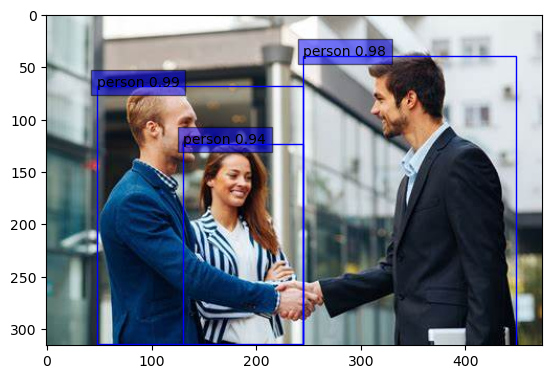

In [24]:
img=Image.open("/kaggle/input/nn-hw2-inference/person.jpg") 
plt.imshow(img)
img = F.convert_image_dtype(F.pil_to_tensor(img),torch.float).unsqueeze(0)
model.eval()
preds = model(img)[0]
ax = plt.gca()
for i in range(len(preds['scores'])):
    if preds['scores'][i]>0.5:
        box = preds['boxes'][i]
        ax.add_patch(plt.Rectangle((box[0].item(), box[1].item()), 
                                   (box[2]-box[0]).item(), (box[3]-box[1]).item(), color="blue", fill=False, linewidth=1))
        ax.text(box[0].item(), box[1].item(), f"person {round(preds['scores'][i].item(),2)}", bbox={'facecolor':'blue', 'alpha':0.5})
# 第三个参数是标签的内容
# bbox里面facecolor是标签的颜色，alpha是标签的透明度
# ax.text(100, 200, "label 0.9", bbox={'facecolor':'blue', 'alpha':0.5})
plt.savefig("./person.jpg")
preds

{'boxes': tensor([[ 359.1086,   99.1604, 1573.9281, 1200.0000]],
        grad_fn=<StackBackward0>),
 'labels': tensor([1]),
 'scores': tensor([0.9787], grad_fn=<IndexBackward0>)}

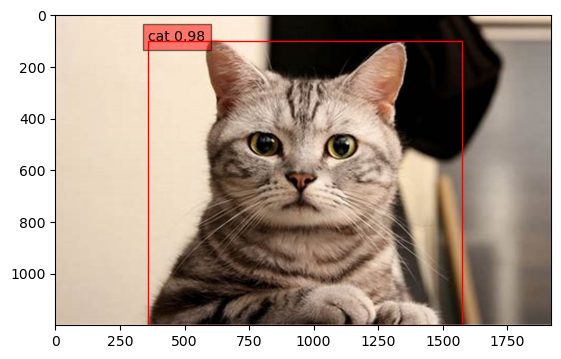

In [25]:
img=Image.open("/kaggle/input/nn-hw2-inference/cat.jpg") 
plt.imshow(img)
img = F.convert_image_dtype(F.pil_to_tensor(img),torch.float).unsqueeze(0)
model.eval()
preds = model(img)[0]
ax = plt.gca()
for i in range(len(preds['scores'])):
    if preds['scores'][i]>0.5:
        box = preds['boxes'][i]
        ax.add_patch(plt.Rectangle((box[0].item(), box[1].item()), 
                                   (box[2]-box[0]).item(), (box[3]-box[1]).item(), color="red", fill=False, linewidth=1))
        ax.text(box[0].item(), box[1].item(), f"cat {round(preds['scores'][i].item(),2)}", bbox={'facecolor':'red', 'alpha':0.5})
# 第三个参数是标签的内容
# bbox里面facecolor是标签的颜色，alpha是标签的透明度
# ax.text(100, 200, "label 0.9", bbox={'facecolor':'blue', 'alpha':0.5})
plt.savefig("./cat.jpg")
preds

{'boxes': tensor([[ 31.4630,  57.5570, 414.3377, 268.0827]], grad_fn=<StackBackward0>),
 'labels': tensor([7]),
 'scores': tensor([0.8644], grad_fn=<IndexBackward0>)}

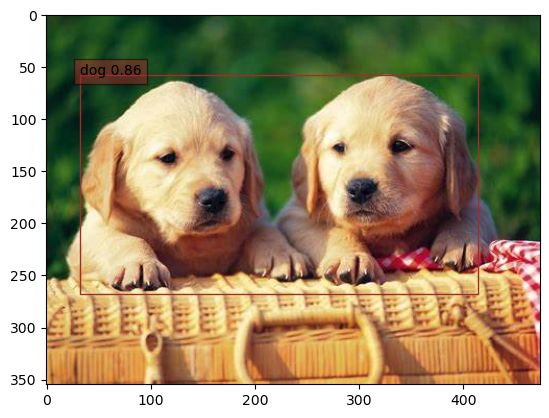

In [27]:
img=Image.open("/kaggle/input/nn-hw2-inference/dog.jpg") 
plt.imshow(img)
img = F.convert_image_dtype(F.pil_to_tensor(img),torch.float).unsqueeze(0)
model.eval()
preds = model(img)[0]
ax = plt.gca()
for i in range(len(preds['scores'])):
    if preds['scores'][i]>0.5:
        box = preds['boxes'][i]
        ax.add_patch(plt.Rectangle((box[0].item(), box[1].item()), 
                                   (box[2]-box[0]).item(), (box[3]-box[1]).item(), color="brown", fill=False, linewidth=1))
        ax.text(box[0].item(), box[1].item(), f"dog {round(preds['scores'][i].item(),2)}", bbox={'facecolor':'brown', 'alpha':0.5})
plt.savefig("./dog.jpg")
preds

In [66]:
dataset = VOCDataset(voc_trainset)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
dataset, dataset_test = torch.utils.data.random_split(dataset, 
                                                      [train_size, test_size])


data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=32, shuffle=True, num_workers=2,
    collate_fn=collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=4, shuffle=False, num_workers=2,
    collate_fn=collate_fn)

imgs, targets = next(iter(data_loader_test))
imgs = list(image.to('cpu') for image in imgs)
image = imgs[0]
idx = targets[0]['image_id'].item()


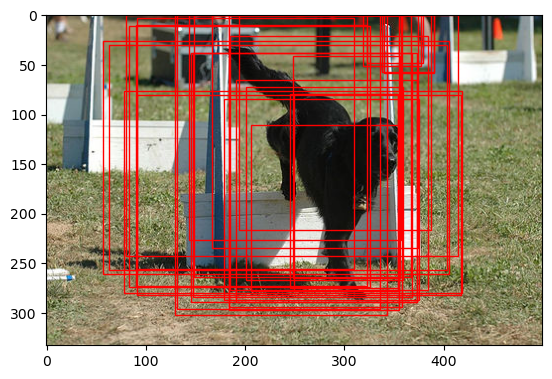

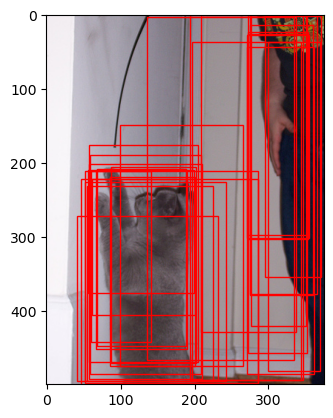

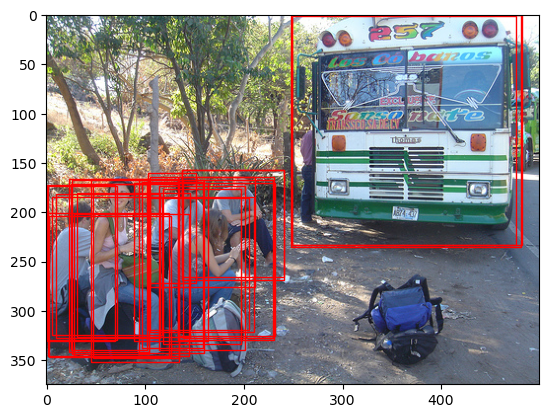

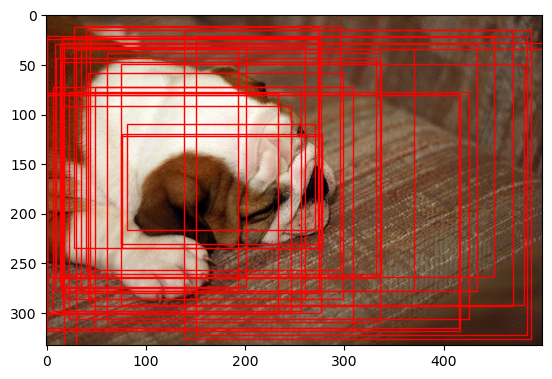

In [75]:
from torchvision.models.detection.image_list import ImageList
import matplotlib.patches as patches
for i in range(4):
    plt.figure()
    image = imgs[i]
    idx = targets[i]['image_id'].item()
    img,_ = voc_trainset[idx]
    plt.imshow(img)
    ax = plt.gca()
    image_l = ImageList(image.unsqueeze(0),[(image.shape[1],image.shape[2])])
    with torch.no_grad():
        model.eval()
        features = model.backbone.forward(image.unsqueeze(0))
        proposals, _ = model.rpn(image_l, features)
    for proposal in proposals[0][:30]:
        x1, y1, x2, y2 = proposal.tolist()
        box = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(box)
    plt.savefig(f'./proposals_{i}.jpg')
        # Draw the proposals on the original image
# fig, ax = plt.subplots(1)
# ax.imshow(img)

# # Draw bounding boxes for a selection of proposals
# # You may want to draw only a subset of the proposals, as there could be thousands of them
# for proposal in proposals[0][:100]:
#     x1, y1, x2, y2 = proposal.tolist()
#     box = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=1, edgecolor='r', facecolor='none')
#     ax.add_patch(box)

# plt.show()

